**Домашнее задание:**

•	К вам приходит руководитель продукта “Интернет-магазин”  
•	И спрашивает про удержание клиентов и повторные покупки  
•	У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали больше оттекать пользователи  
•	Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году? 

Данные лежат в папке занятия на сервере:  
•	есть транзакции (покупки) в интернет магазине, в том числе id клиента, id покупки, timestamp покупки и тп  
•	orders.csv, customers.csv  

Ваши задачи:   
1.	Проверить гипотезу руководителя продукта   
2.	Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы


**Гипотеза:** Отток пользователей в 2017 году больше, чем отток в 2016.

Проведем когортный анализ, посмотрим на retention, т.к. сможем понять и про то, как пользователи возвращаются, и про то, как оттекают (обратно к retention). 

Код визуализации был взят из [статьи](https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea)

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [3]:
from operator import attrgetter

In [4]:
df_orders = pd.read_csv('orders.csv')

In [5]:
df_orders.head()

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376


In [6]:
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [7]:
df_customers.head()

,customer_id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [8]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')

In [9]:
df_merge['order_date'] = pd.to_datetime(df_merge['order_date'])

In [10]:
df_merge['order_month'] = df_merge['order_date'].dt.to_period('M')
df_merge['cohort_month'] = df_merge.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [11]:
df_merge['order_quart'] = df_merge['order_date'].dt.to_period('Q')
df_merge['cohort_quart'] = df_merge.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period('Q')

In [12]:
df_merge['order_year'] = df_merge['order_date'].dt.to_period('Y')
df_merge['cohort_year'] = df_merge.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period('Y')

In [13]:
df_merge.head()

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city,order_month,cohort_month,order_quart,cohort_quart,order_year,cohort_year
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion,2014-09,2014-09,2014Q3,2014Q3,2014,2014
1,131884,2015-12-06,Same Day,DK-13375,594.002,Dennis Kane,Consumer,Ohio,Marion,2015-12,2014-09,2015Q4,2014Q3,2015,2014
2,145065,2015-12-12,First,DK-13375,32.308,Dennis Kane,Consumer,Ohio,Marion,2015-12,2014-09,2015Q4,2014Q3,2015,2014
3,133046,2017-07-27,Second,DK-13375,297.990,Dennis Kane,Consumer,Ohio,Marion,2017-07,2014-09,2017Q3,2014Q3,2017,2014
4,165099,2017-12-11,First,DK-13375,1.392,Dennis Kane,Consumer,Ohio,Marion,2017-12,2014-09,2017Q4,2014Q3,2017,2014


In [14]:
df_cohort_month = df_merge.groupby(['cohort_month', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort_month['period_number'] = (df_cohort_month.order_month - df_cohort_month.cohort_month).apply(attrgetter('n'))

In [15]:
df_cohort_quart = df_merge.groupby(['cohort_quart', 'order_quart']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort_quart['period_number'] = (df_cohort_quart.order_quart - df_cohort_quart.cohort_quart).apply(attrgetter('n'))

In [16]:
df_cohort_year = df_merge.groupby(['cohort_year', 'order_year']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort_year['period_number'] = (df_cohort_year.order_year - df_cohort_year.cohort_year).apply(attrgetter('n'))

In [17]:
cohort_pivot_m = df_cohort_month.pivot_table(index = 'cohort_month',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [18]:
cohort_pivot_q = df_cohort_quart.pivot_table(index = 'cohort_quart',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [19]:
cohort_pivot_y = df_cohort_year.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [20]:
cohort_size_m = cohort_pivot_m.iloc[:,0]
retention_matrix_m = cohort_pivot_m.divide(cohort_size_m, axis = 0)

cohort_size_q = cohort_pivot_q.iloc[:,0]
retention_matrix_q = cohort_pivot_q.divide(cohort_size_q, axis = 0)

cohort_size_y = cohort_pivot_y.iloc[:,0]
retention_matrix_y = cohort_pivot_y.divide(cohort_size_y, axis = 0)

Рассмотрим годовой retention по когортам. Чем больше retention, тем меньше, отток пользователей. 

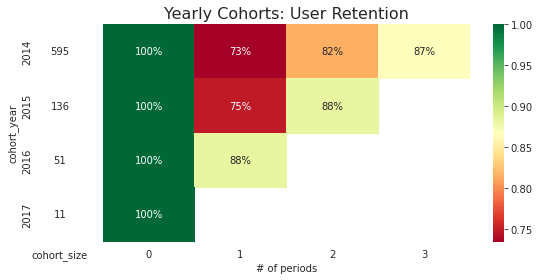

In [21]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_y, 
                mask=retention_matrix_y.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_y).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Для старых пользователей (те, кто пришел в 2014, 2015 годах) retention 2016 года хуже чем в 2017. Новые пользователи, пришедшие в 2016 году, вернулись в 2017 лучше, чем предыдущие когорты возвращались через 1 год.

При этом в 2017 по сравнению с 2016 кол-во новых пользователей довольно сильно упало, но общее число пользователей выросло.

Поскольку годовой анализ не очень объемный, посмотрим по месяцам.

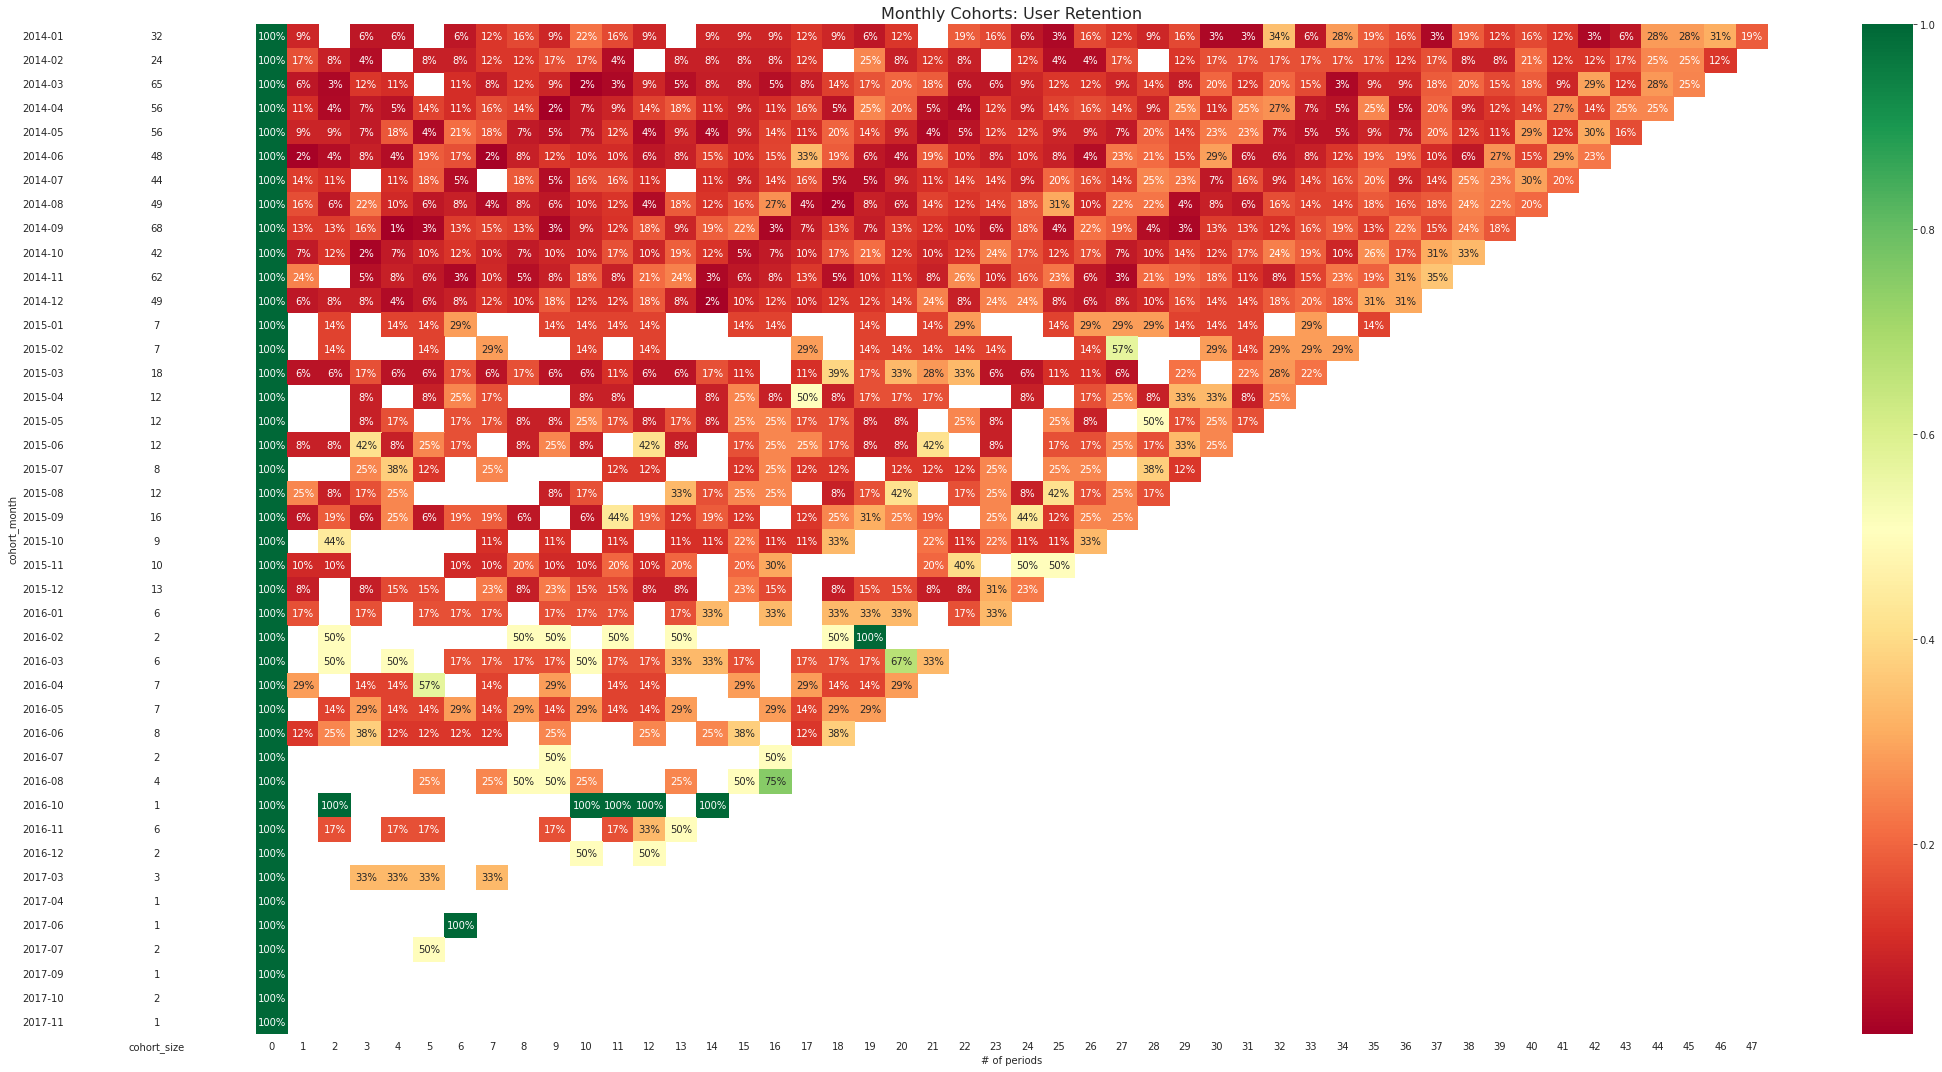

In [22]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(30, 15), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_m, 
                mask=retention_matrix_m.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_m).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Очень тяжелый график. Много пропусков в данных особенно после второй половины 2016 года. Сразу же бросается в глаза сезонность в декабре-январе ( темно красные диагонали), в это время происходит наибольший отток. Посмотрим сначала на старых пользователей (2014-2015 года). Для когорты 2014 отток в 2017 стал меньше, чем в 2016. Для 2015 на первый взгляд тяжелее сказать. Для пользователей пришедших в 2016-2017 из-за небольшого количества новых пользователей трудно судить. 

Поэтому посмотрим на вариант когорт по кварталам. Так мы сможем разбить людей сильнее на группы, чем по годам, но не так сильно, как по месяцам.

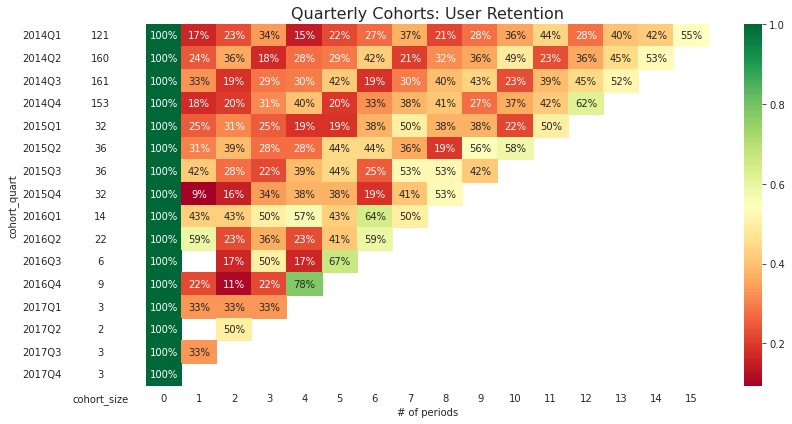

In [23]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_q, 
                mask=retention_matrix_q.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Quarterly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_q).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Поквартальный график выглядит поприятнее. Вспоминаем про сезонность в оттоке, которую мы увидели в декабре, на месячном графике. В целом на поквартальном графике мы тоже ее можем видеть для 4 кварталов, переходя немного на первый.
Анализируя график, можно сказать, что как для старых, так и для новых пользователей отток в 2016 был сильнее, чем в 2017 году.

Однако есть смысл посмотреть на ретеншн/отток с точки зрения денег и заказов. Покупают ли хуже возвращающиеся пользовтаели или нет? Посмотрим на это с точки зрения годовых показателей.

In [24]:
df_cohort_year_tr = df_merge.groupby(['cohort_year', 'order_year']) \
              .agg(n_transactions=('id', 'count')) \
              .reset_index(drop=False)
df_cohort_year_tr['period_number'] = (df_cohort_year_tr.order_year - df_cohort_year_tr.cohort_year).apply(attrgetter('n'))

cohort_pivot_y_tr = df_cohort_year_tr.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'n_transactions')

cohort_size_y_tr = cohort_pivot_y_tr.iloc[:,0]

retention_matrix_y_tr = cohort_pivot_y_tr.divide(cohort_size_y_tr, axis = 0)

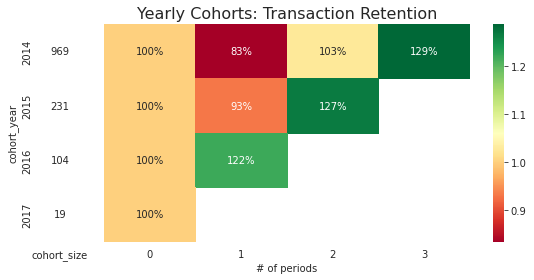

In [25]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_y_tr, 
                mask=retention_matrix_y_tr.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: Transaction Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_y_tr).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Transaction Retention для 2017 выглядит лучше, чем для 2016 (для когорт 2014-2015 явно видно, для когорты 2016, можем судить по ретеншену через год, относительно других когорт). Вернувшиеся пользователи по когортам стали совершать больше покупок, по сравнению с предыдущем годом. Пришедшие пользователи в 2017 стали совершать меньше покупок в общем, чем пользователи, которые приходили впервые в другие года.

In [26]:
df_cohort_year_s = df_merge.groupby(['cohort_year', 'order_year']) \
              .agg(sales=('sales', 'sum')) \
              .reset_index(drop=False)
df_cohort_year_s['period_number'] = (df_cohort_year_s.order_year - df_cohort_year_s.cohort_year).apply(attrgetter('n'))

cohort_pivot_y_s = df_cohort_year_s.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'sales')

cohort_size_y_s = cohort_pivot_y_s.iloc[:,0]

retention_matrix_y_s = cohort_pivot_y_s.divide(cohort_size_y_s, axis = 0)

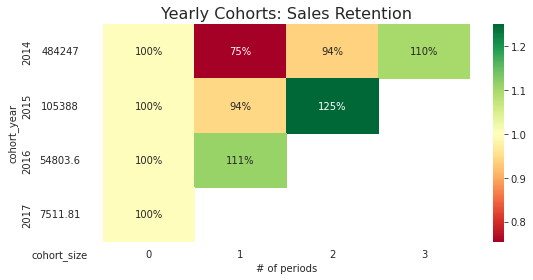

In [27]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix_y_s, 
                mask=retention_matrix_y_s.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Yearly Cohorts: Sales Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size_y_s).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

Ситуация про продажам аналогичная.

In [28]:
df_merge.groupby('order_year').agg({'sales':['sum'], 'id':['count']})

,sales,id
,sum,count
order_year,,
2014,484247.4981,969
2015,470532.5090,1038
2016,609205.5980,1315
2017,733215.2552,1687


In [29]:
retention_matrix_y_s

period_number,0,1,2,3
cohort_year,,,,
2014,1.0,0.754044,0.939413,1.100728
2015,1.0,0.944065,1.250350,NaN
2016,1.0,1.111355,NaN,NaN
2017,1.0,NaN,NaN,NaN


Можно посмотреть по разным сегментам, например по ship_mode, segment или state. По штатам слишком мало данных, поэтому посмотрим ретеншн по ship_mode и segment.

Посмотрим по годам.

**Users Retention by segment**

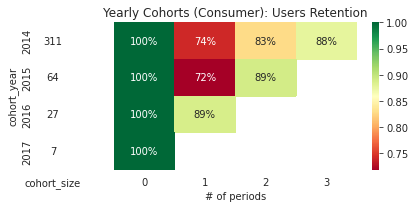

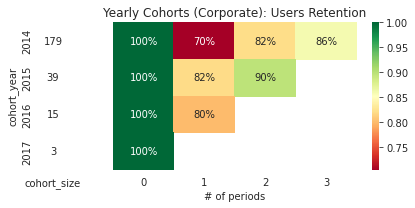

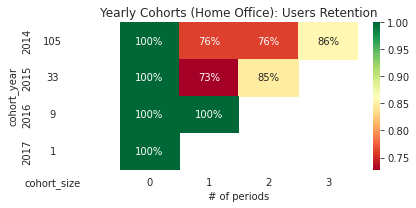

In [30]:
for segment in df_merge.segment.unique():
    df = df_merge[df_merge.segment==segment].groupby(['cohort_year', 'order_year', 'segment']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
    df['period_number'] = (df.order_year - df.cohort_year).apply(attrgetter('n'))
    cohort_pivot = df.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'n_customers')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
      fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
      # retention matrix
      sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                  fmt='.0%', cmap='RdYlGn', ax=ax[1])
      ax[1].set_title(f'Yearly Cohorts ({segment}): Users Retention', fontsize=12)
      ax[1].set(xlabel='# of periods', ylabel='')

      # cohort size
      cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
      white_cmap = mcolors.ListedColormap(['white'])
      sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, 
                  ax=ax[0])

      fig.tight_layout()

Для сегмента Consumer и Home office кол-во вернувшихся пользователей в 2017 в целом больше, также наблюдается положительная динамика, возвращения через год. Для сегмента Corporate для старых пользователей (2014-2015 год первой покупки) ретеншн лучше, для новых нельзя точно сказать.

Users Retention by ship mode не будем рассматривать, т.к. нельзя сделать однозначный вывод про пользователя.

**Sales Retention by segment**

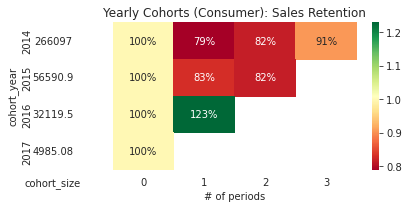

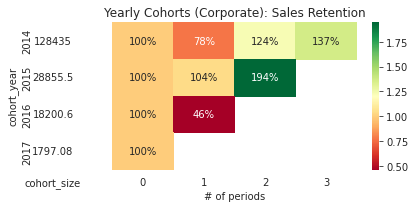

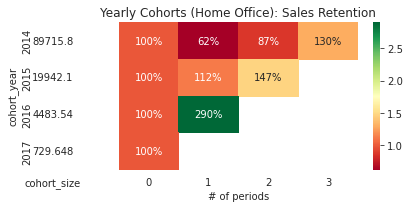

In [31]:
for segment in df_merge.segment.unique():
    df = df_merge[df_merge.segment==segment].groupby(['cohort_year', 'order_year', 'segment']) \
              .agg(sales=('sales', 'sum')) \
              .reset_index(drop=False)
    df['period_number'] = (df.order_year - df.cohort_year).apply(attrgetter('n'))
    cohort_pivot = df.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'sales')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
      fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
      # retention matrix
      sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                  fmt='.0%', cmap='RdYlGn', ax=ax[1])
      ax[1].set_title(f'Yearly Cohorts ({segment}): Sales Retention', fontsize=12)
      ax[1].set(xlabel='# of periods', ylabel='')

      # cohort size
      cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
      white_cmap = mcolors.ListedColormap(['white'])
      sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, 
                  ax=ax[0])

      fig.tight_layout()

По  продажам сегмент Consumer и Home office  возвращение лучше в 2017 году, в целом по всем когортам. Для сегмента Corporate хуже для когорты first oder 2016.

**Sales Retention by ship mode**

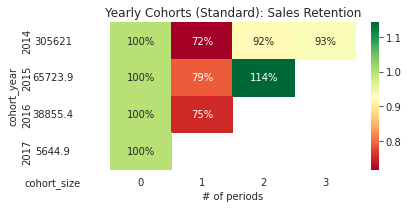

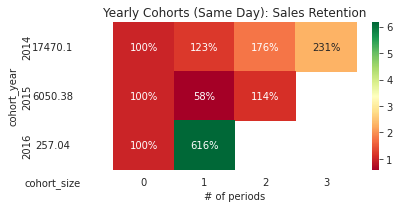

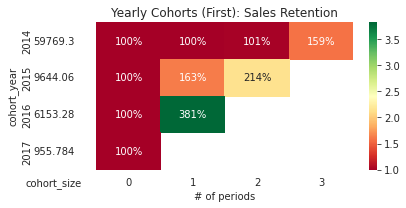

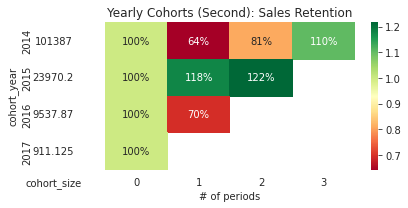

In [32]:
for ship_mode in df_merge.ship_mode.unique():
    df = df_merge[df_merge.ship_mode==ship_mode].groupby(['cohort_year', 'order_year', 'ship_mode']) \
              .agg(sales=('sales', 'sum')) \
              .reset_index(drop=False)
    df['period_number'] = (df.order_year - df.cohort_year).apply(attrgetter('n'))
    cohort_pivot = df.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'sales')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
      fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
      # retention matrix
      sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                  fmt='.0%', cmap='RdYlGn', ax=ax[1])
      ax[1].set_title(f'Yearly Cohorts ({ship_mode}): Sales Retention', fontsize=12)
      ax[1].set(xlabel='# of periods', ylabel='')

      # cohort size
      cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
      white_cmap = mcolors.ListedColormap(['white'])
      sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, 
                  ax=ax[0])

      fig.tight_layout()

Ретеншн по продажам доставка First стал лучше в 2017, Standart и Second сильный отток в когорте first oder 2016, для других 2017 лучше. Same day для когорт 2014-2016 лучше, в 2017 не было новых пользователей с доставкой Same day.

**Transactions Retention by segment**

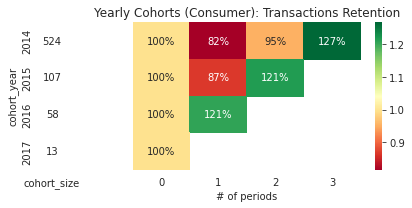

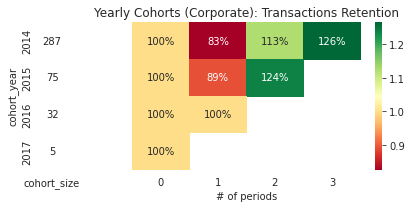

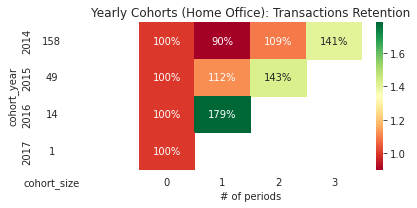

In [33]:
for segment in df_merge.segment.unique():
    df = df_merge[df_merge.segment==segment].groupby(['cohort_year', 'order_year', 'segment']) \
              .agg(id=('id', 'count')) \
              .reset_index(drop=False)
    df['period_number'] = (df.order_year - df.cohort_year).apply(attrgetter('n'))
    cohort_pivot = df.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'id')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
      fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
      # retention matrix
      sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                  fmt='.0%', cmap='RdYlGn', ax=ax[1])
      ax[1].set_title(f'Yearly Cohorts ({segment}): Transactions Retention', fontsize=12)
      ax[1].set(xlabel='# of periods', ylabel='')

      # cohort size
      cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
      white_cmap = mcolors.ListedColormap(['white'])
      sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, 
                  ax=ax[0])

      fig.tight_layout()

Transaction Retention 2017 в сегментах Consumer и Home office больше, сегмент Coporate лучше для старых пользователей, для когорты 2016 без изменений.

**Transactions Retention by ship mode**

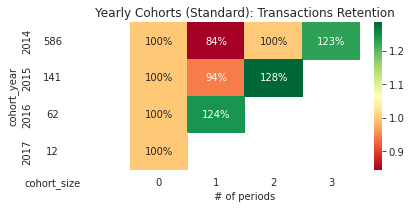

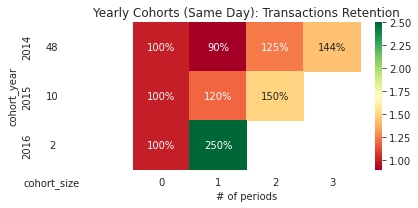

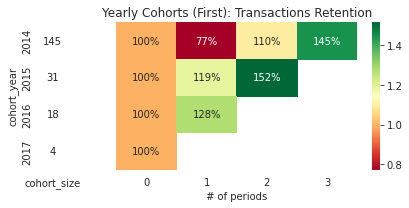

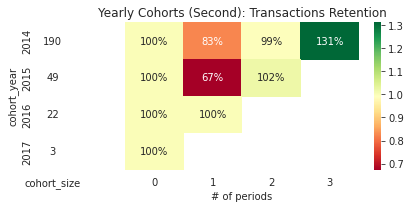

In [34]:
for ship_mode in df_merge.ship_mode.unique():
    df = df_merge[df_merge.ship_mode==ship_mode].groupby(['cohort_year', 'order_year', 'ship_mode']) \
              .agg(id=('id', 'count')) \
              .reset_index(drop=False)
    df['period_number'] = (df.order_year - df.cohort_year).apply(attrgetter('n'))
    cohort_pivot = df.pivot_table(index = 'cohort_year',
                                     columns = 'period_number',
                                     values = 'id')
    cohort_size = cohort_pivot.iloc[:,0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

    with sns.axes_style("white"):
      fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
      
      # retention matrix
      sns.heatmap(retention_matrix, mask=retention_matrix.isnull(), annot=True, 
                  fmt='.0%', cmap='RdYlGn', ax=ax[1])
      ax[1].set_title(f'Yearly Cohorts ({ship_mode}): Transactions Retention', fontsize=12)
      ax[1].set(xlabel='# of periods', ylabel='')

      # cohort size
      cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
      white_cmap = mcolors.ListedColormap(['white'])
      sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, 
                  ax=ax[0])

      fig.tight_layout()

Transaction Retention by ship mode Standart, First для всех когорт лучше. Second для когорты 2014 лучше, для 2015-2016 без особых изменений. Same day для когорт 2014-2016 лучше, в 2017 не было новых пользователей с доставкой Same day.

**Выводы:**

В целом, отток пользователей в 2017 году стал меньше, чем в 2016, а retention стал больше в 2017 по сравнению с 2016. Это наблюдается, как для старых пользователей (сделали первый заказ в  в 2014-2015, retention 2017 > retention 2016), так и для более новых, сделали первый заказ в 2016, через год вернулось пользователей больше, чем возвращалось через год в других когортах).

Однако, в общем, количество новых пользователей, которые сделали первый заказ в 2017, значительно уменьшилось по сравнению с пользователями, которые были новыми в предыдущие года.

Аналогичные выводы можно сделать по Transaction Retention и Sales Retention.

При анализе когорт по принципу первого заказа помесячно и поквартально, обнаружили сезонность с сильным отттоком в декабре-январе каждого года. Стоит обратить на это внимание.

При анализе по сегментам (Consumer, Corporate, Home Office) выявлено, что отток (users/transactions/sales) в целом меньше в 2017, чем в 2016, кроме когорты first oder 2016 в сегменте Corporate (слабая).

При анализе по способу доставки (Standart, First, Second, Same day):
- transactions: отток меньше в 2017 году, кроме когорты first oder 2015-2016 тип доставки Second (слабые).
- sales: отток меньше в 2017 году, кроме когорты first oder 2016 тип доставки Second, Standart (слабые).
В 2017 не было новых пользователей с доставкой Same day.

Таким образом, гипотеза не подтверждается, отток не стал больше. Однако надо обратить внимание на динамику снижения появления числа новых пользователей с каждым годом, на оттоки пользователей в декабре-январе, слабые когорты и отсутсвие заказов от пользователей пришедших в 2017 году доставки same day.

В качестве инструмента принятия решения, предлагаем использовать поквартальный когортный анализ, а также когортный анализ по годам с разбивкой на различные сегменты.


